In [2]:
IN_COLAB = 'google.colab' in str(get_ipython())
if IN_COLAB:
	!pip install seaborn
	!pip install statsmodels
	!pip install pycaret
	!pip install pyod
# Note pycaret and pmdarima libraries are incompatible for version 2021/12/24

# Anomaly Detection Methods

1. Function to run PyCaret or PyOD Models
2. Code to gather results
3. Viewing Results
   - Visualization of results for Global Outliers


In [3]:
import pandas as pd
from data.jpx import *
from utils.outlier import *
from pycaret.anomaly import *
import random
from sklearn import metrics
TSE33 = TOPIX_SECTORS()
NKY = Nikkei225() 
try:
	s
except NameError:
	inst = NKY.get_ric("6758.T")  # Small cap 1332, 3103, 5707, 6703,    Large cap 6758, 7203, 6098 9432
	print(f"inst: {inst}")
	s = Stock(inst, TSE33)
else:
    print(s.df_intraday.drop(columns=["COUNT", "VOLUME", "DATE", "TIME", "CLOSE_TPX", "RETURN_ADJ_TPX", "RETURN_NORM_TPX"]).head())

inst: [132 '6758.T' 'Sony Group Corp' 'Electric Appliances']


In [8]:
# Import PyOD models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.pca import PCA
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.deep_svdd import DeepSVDD

outliers_fraction = 0.02
random_state = np.random.RandomState(42)

pyod_classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Local Outlier Factor (LOF)':LOF(n_neighbors=35, contamination=outliers_fraction),
        'Principal Component Analysis (PCA)': PCA(contamination=outliers_fraction),
        'One-Class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
        'AutoEncoder (AE)': AutoEncoder(hidden_neurons=[25, 2, 2, 25], epochs=30, verbose=0, contamination=outliers_fraction),
        'DeepSVDD (DeepSVDD)': AutoEncoder(hidden_neurons=[25, 2, 2, 25], epochs=30, verbose=0, contamination=outliers_fraction)   
}


## 1. Function to run PyCaret or PyOD Models
and return results in order of most likely outlier to least likely outlier

In [9]:

def method(model_name: str, data: pd.DataFrame):
	"""Takes PyOD or PyCaret model name and data outputs list anomalies in order of probability
	Args:
		model (str): the model name
		data (DataFrame): data points
	Returns:
		list in order
	"""
	data = data.dropna()
	if model_name[0:1].islower():
		pycaret_setup = setup(data, session_id = 100, silent=True)
		model = create_model(model_name, fraction=outliers_fraction)
		# evaluate_model(model)
		results = assign_model(model).sort_values(by=['Anomaly_Score'], ascending=False)
	else:
		clf  = pyod_classifiers[model_name]
		clf.fit(data)
		# predict raw anomaly score
		scores = clf.decision_function(data)
		# print(scores)
		results = data
		results['Anomaly_Score'] = scores
		results = results.sort_values(by=['Anomaly_Score'], ascending=False)
	return results.reset_index(drop=True)

# # Test
# df = s.window(s.unique_dates[0], wdw_len=0)
# data, anomaly = injectOutlier(df, "RETURN_NORM", "Global", anomaly=8)
# results = method("AutoEncoder (AE)", data)
# print(f"anomaly: {anomaly}   results: {type(results)}")
# print(results[0:10])


     index  RETURN_NORM      time  Anomaly  Anomaly_Score
281    281     0.993308  0.952542        1       0.356678
8        8     1.000000  0.027119        1       0.339333
277    277     0.929384  0.938983        1       0.292947
272    272     0.000000  0.922034        1       0.289679
32      32     0.909375  0.108475        1       0.250112

## 2. Code to gather results 
across stocks, model types, and outlier types
stored in results.txt

inst: [132 '6758.T' 'Sony Group Corp' 'Electric Appliances']
μ: 0.45785690825890163   σ: 0.1372199522854169    MAD: 0.0782037012223476   first: 283
   index  RETURN_NORM      time  Anomaly_Score
0    283     1.000000  0.959322       4.116194
1    281     0.993308  0.952542       4.058164
2      1     0.089427  0.003390       4.014693
3    272     0.000000  0.922034       3.944166
4     32     0.909375  0.108475       3.753142
[0]
Global, AutoEncoder (AE), 6758.T, 1.0, 1.0, 1.0, 1.0

index            283.000000
RETURN_NORM        1.000000
time               0.959322
Anomaly_Score      4.116194
Name: 0, dtype: float64
anomaly: 283  ranking: 0


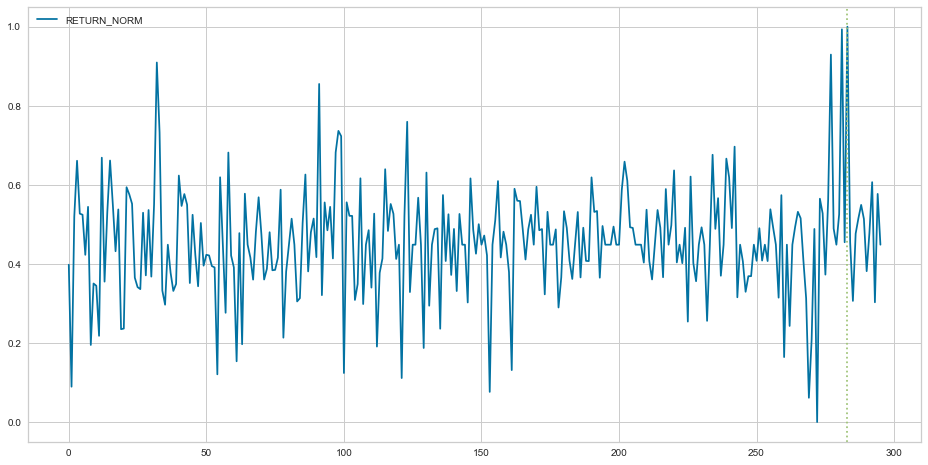

In [7]:

for stock in [6758]:   # [1332, 3103, 5707, 6703, 6098, 6758, 7203, 9432]: 
	inst = NKY.get_ric(f"{str(stock)}.T")
	# s = Stock(inst, TSE33)
	print(f"inst: {inst}")
	# Models starting with lowercase use PyCaret, Upper Case use PyOD library
	#                  ['abod', 'cluster', 'histogram', 'iforest', 'knn', 'lof', 'pca', 'svm', 'AutoEncoder (AE)', 'DeepSVDD (DeepSVDD)']:
	for model_name in  ['AutoEncoder (AE)']:
		for outlier_type in ["Global"]: # ["Global", "Contextual", "Collective", "All Three"]:
			for no_to_find in [0]:  #[0,1,2]  only used for 'All Three' 
				y_preds = []
				y_trues = []
				rankings = []
				anomalies = []

				field, start, end = "RETURN_NORM", 0, 1 # len(s.unique_dates)
				for i in range(start, end):
					df = s.window(s.unique_dates[i], wdw_len=0)
					data, anomaly = injectOutlier(df, field, outlier_type)
					# print(data.head())
					# data.drop(columns='TIME').plot()
					# # # data[[field, field+'_tpx']].plot()
					# plt.axvline(x=anomaly, ls=':', c='g')
					pred = method(model_name, data)
					print(pred.head())
					if outlier_type != "All Three":
						ranking = np.where(pred["index"]==anomaly)[0][0]
						if outlier_type == "Collective":
							the_end = min(anomaly+10, len(pred))
							ranking = len(pred)
							for i in range(anomaly-2, the_end):
								ranking2 = np.where(pred["index"]==i)[0][0]
								ranking = min(ranking,ranking2)
						y_pred = np.zeros(len(pred), dtype=int)
						y_pred[:ranking+1] = 1
						y_preds = np.append(y_preds, y_pred)
						y_true = np.zeros_like(y_pred)
						y_true[ranking] = 1
						y_trues = np.append(y_trues, y_true)
						rankings.append(ranking)
					else:
						ranking1 = np.where(pred["index"]==75)[0][0]
						ranking2 = np.where(pred["index"]==150)[0][0]
						ranking3 = len(pred)
						for i in range(223, 235):
							ranking_temp = np.where(pred["index"]==i)[0][0]
							ranking3 = min(ranking3,ranking_temp)
						y_pred = np.zeros(len(pred), dtype=int)
						ranking123 = sorted([ranking1, ranking2, ranking3])
						print(ranking123)
						y_pred[:ranking123[no_to_find]+1] = 1
						y_preds = np.append(y_preds, y_pred)
						y_true = np.zeros_like(y_pred)
						y_true[ranking123[0]] = 1
						y_true[ranking123[1]] = 1
						y_true[ranking123[2]] = 1
						y_trues = np.append(y_trues, y_true)
						rankings.append(ranking123)
					anomalies.append(pred.Anomaly_Score.sum())

				run_metrics = f"{outlier_type}, {model_name}, {inst[1]}, {metrics.accuracy_score(y_trues, y_preds)}, {metrics.precision_score(y_trues, y_preds)}, {metrics.recall_score(y_trues, y_preds)}, {metrics.f1_score(y_trues, y_preds)}\r\n"
				
				if (end-start) < 11:
					print (rankings)
					print(run_metrics)
					print(pred.iloc[ranking])
					print(f"anomaly: {anomaly}  ranking: {ranking}")
					ax = data.drop(columns=['index','time']).plot(figsize=(16, 8))
					if outlier_type != "All Three":
						ax.axvline(x=anomaly, ls=':', c='g')
					else:
						ax.axvline(x=75, ls=':', c='g')
						ax.axvline(x=150, ls=':', c='g')
						ax.axvline(x=225, ls=':', c='g')
				else:
					with open('results.txt', "a") as file_object:
						file_object.write(run_metrics)

## 3. Viewing Data

In [4]:
anomaly = 'Global'  # 'Global' 'Contextual' 'Collective' 'All Three'  1332, 6758, 7203
# ['abod', 'cluster', 'histogram', 'knn', 'iforest', 'lof', 'pca', 'svm']
table_df = pd.read_csv('./data/results/results.txt', names=['Anomaly', 'Model', 'Stock', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print(len(table_df))
table_df['Stock'] = table_df['Stock'].apply(lambda x: str(x).strip())
table_df['Model'] = table_df['Model'].apply(lambda x: str(x).strip())
# table_df = table_df[table_df['Anomaly'] == anomaly]
# table_df = table_df[table_df['Model'] == 'DeepSVDD']
#table_df = table_df[table_df['Stock'] == '6758.T']
# table_df = table_df.loc[table_df['Stock'].isin(['6098.T', '6758.T', '7203.T', '9432.T'])]  # Large Cap Stocks
# table_df = table_df.loc[table_df['Stock'].isin(['1332.T', '3103.T', '5707.T', '6703.T'])]  # Small Cap Stocks
# grouped = table_df.groupby('Model').mean()
# table_df = grouped.sort_values(by=['Recall', 'F1 Score'], ascending=False).reset_index()
table_df=table_df.sort_values(by=['F1 Score', 'Recall', 'Model'], ascending=False).drop(columns=[]).reset_index()
table_df.head(20)

263


,index,Anomaly,Model,Stock,Accuracy,Precision,Recall,F1 Score
0,21,Collective,arima,6098.T,1.000000,1.000000,1,1.000000
1,24,Collective,arima,9432.T,0.999986,0.995935,1,0.997963
2,110,Contextual,arima,7203.T,0.999932,0.980000,1,0.989899
3,17,Collective,arima,6758.T,0.999918,0.976096,1,0.987903
4,153,Contextual,lof,7203.T,0.999836,0.953307,1,0.976096
5,109,Contextual,arima,6098.T,0.999822,0.949612,1,0.974155
6,90,Contextual,abod,7203.T,0.999809,0.945946,1,0.972222
7,157,Contextual,lof,6098.T,0.999767,0.935115,1,0.966469
8,94,Contextual,abod,6098.T,0.999726,0.924528,1,0.960784
9,86,Collective,svm,6098.T,0.999685,0.914179,1,0.955166
